<a href="https://colab.research.google.com/github/anujott-codes/Credit-Loan-Approval/blob/main/Credit_Approval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [52]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

##Credit Card Approval

###import dataset

In [53]:
#using credit dataset from kaggle derived from UCI
credit_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Machine Learning/Project/Credit Card and Loan Approval/credit_approval_dataset.csv")
credit_df.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,0,ByOtherMeans,120,0,1


###EDA

In [54]:
#info regarding dataset
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          690 non-null    int64  
 1   Age             690 non-null    float64
 2   Debt            690 non-null    float64
 3   Married         690 non-null    int64  
 4   BankCustomer    690 non-null    int64  
 5   Industry        690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    int64  
 9   Employed        690 non-null    int64  
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    int64  
 12  Citizen         690 non-null    object 
 13  ZipCode         690 non-null    int64  
 14  Income          690 non-null    int64  
 15  Approved        690 non-null    int64  
dtypes: float64(3), int64(10), object(3)
memory usage: 86.4+ KB


In [55]:
#unique values per column
credit_df.nunique()

,0
Gender,2
Age,350
Debt,215
Married,2
BankCustomer,2
Industry,14
Ethnicity,5
YearsEmployed,132
PriorDefault,2
Employed,2


In [56]:
#description of the dataset
credit_df.describe()

,Gender,Age,Debt,Married,BankCustomer,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,ZipCode,Income,Approved
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000
mean,0.695652,31.514116,4.758725,0.760870,0.763768,2.223406,0.523188,0.427536,2.40000,0.457971,180.547826,1017.385507,0.444928
std,0.460464,11.860245,4.978163,0.426862,0.425074,3.346513,0.499824,0.495080,4.86294,0.498592,173.970323,5210.102598,0.497318
min,0.000000,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.670000,1.000000,1.000000,1.000000,0.165000,0.000000,0.000000,0.00000,0.000000,60.000000,0.000000,0.000000
50%,1.000000,28.460000,2.750000,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,160.000000,5.000000,0.000000
75%,1.000000,37.707500,7.207500,1.000000,1.000000,2.625000,1.000000,1.000000,3.00000,1.000000,272.000000,395.500000,1.000000
max,1.000000,80.250000,28.000000,1.000000,1.000000,28.500000,1.000000,1.000000,67.00000,1.000000,2000.000000,100000.000000,1.000000


In [57]:
#extracting numerical features and categorical features
num_features = credit_df.select_dtypes(exclude='O').columns.to_list()
cat_features = credit_df.select_dtypes(include='O').columns.to_list()

print("----- Numerical Features -----")
print(num_features)
print(f"Total : {len(num_features)}")
print("\n")
print("----- Categorical Features -----")
print(cat_features)
print(f"Total : {len(cat_features)}")

----- Numerical Features -----
['Gender', 'Age', 'Debt', 'Married', 'BankCustomer', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'ZipCode', 'Income', 'Approved']
Total : 13


----- Categorical Features -----
['Industry', 'Ethnicity', 'Citizen']
Total : 3


In [58]:
#function to plot distributions
def plot(df, col ,num):
  plt.subplot(4,4,num)
  sns.histplot(data = df,x=col,kde=True, color='skyblue')
  plt.title(f"{col} Distribution")
  plt.xlabel(" ")

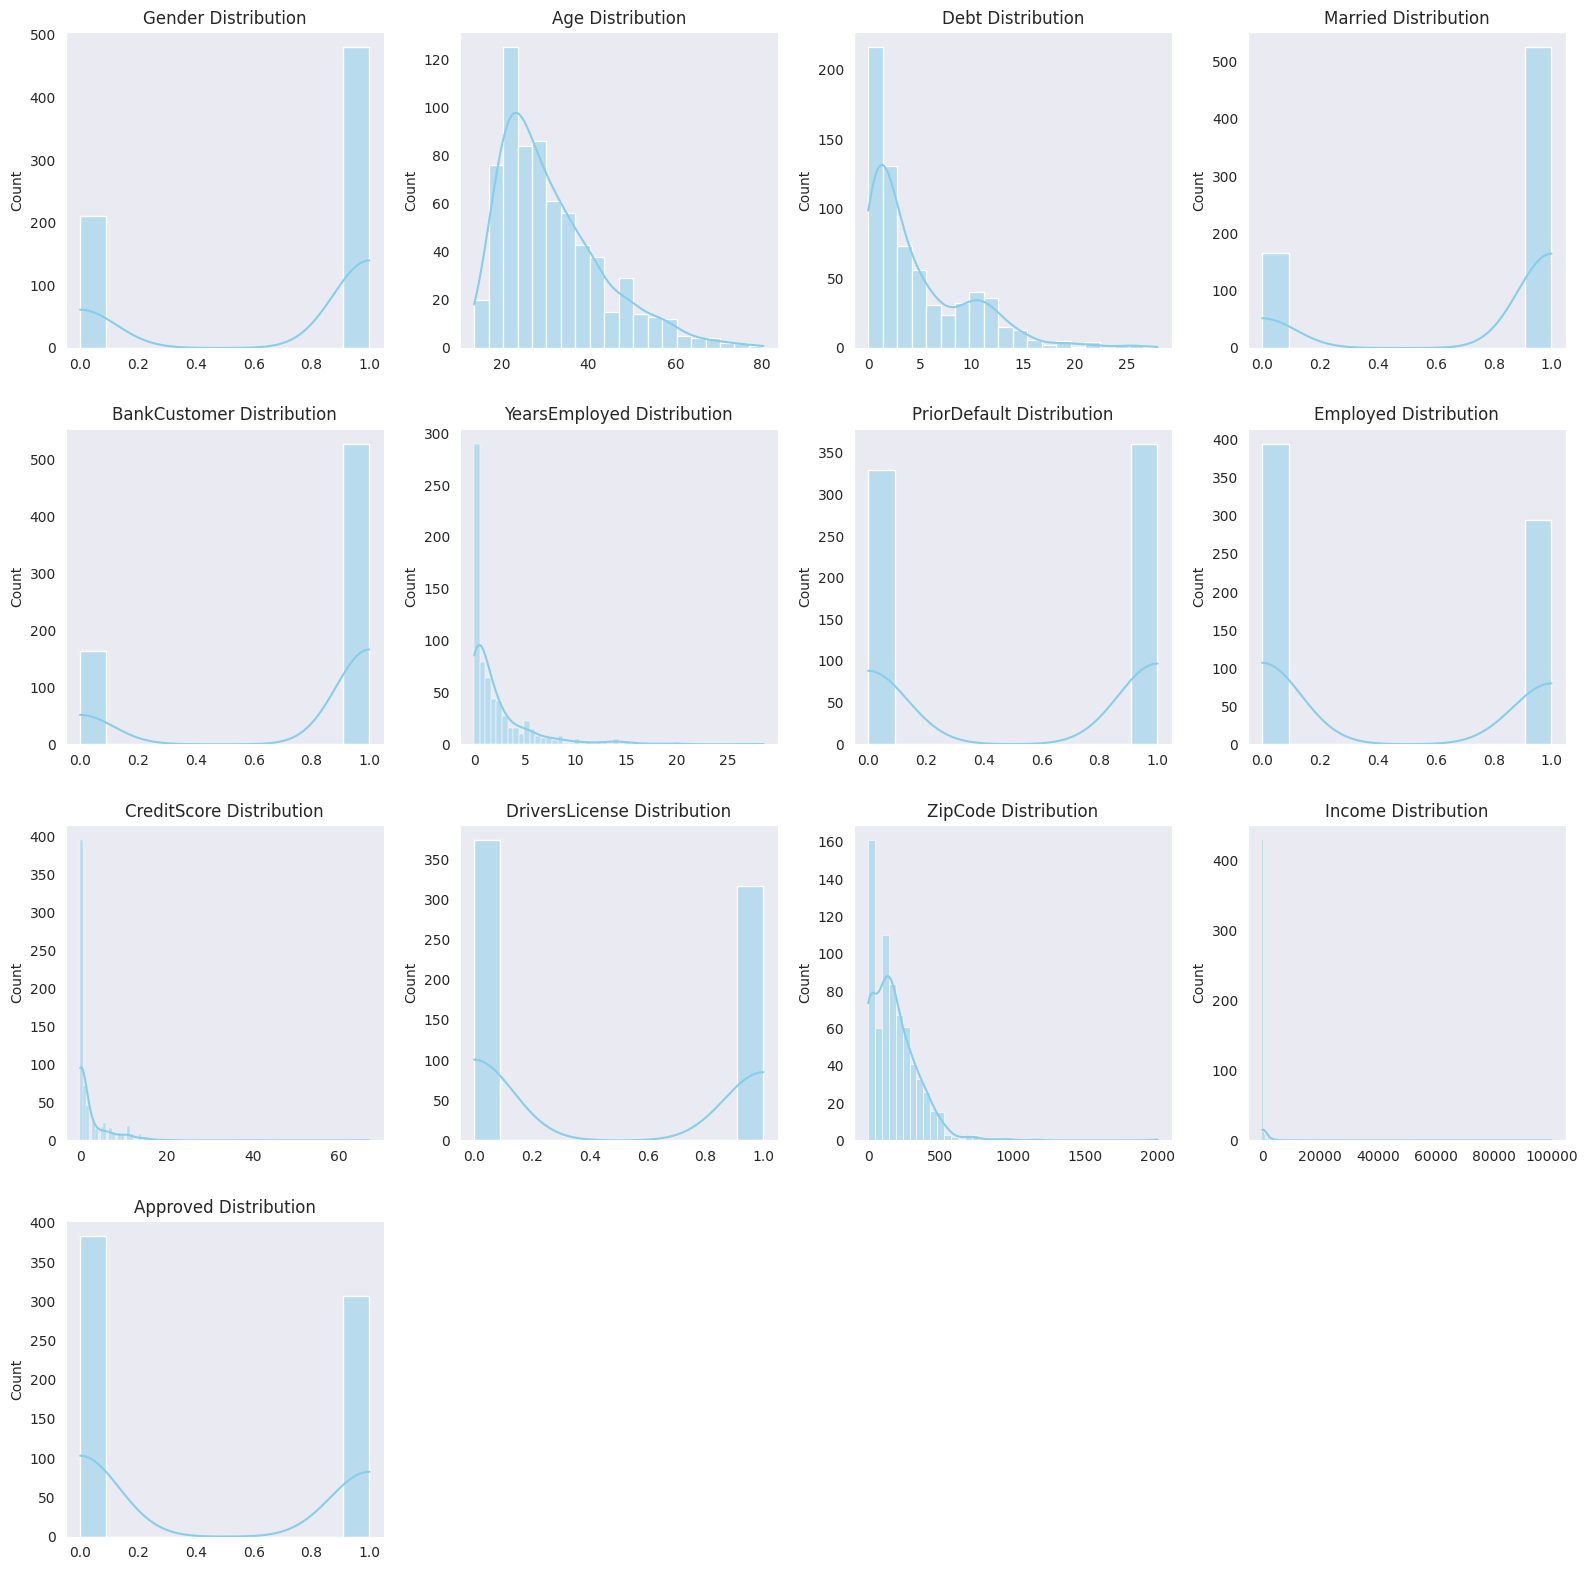

In [59]:
#plotting distributions
plt.figure(figsize=(16,16))
for i,col in enumerate(num_features):
  plot(credit_df,col,i+1)

plt.tight_layout()
plt.show()

Debt,Incmome and Credit Score have been already scaled

In [60]:
#function for pie chart
def pie_plot(col, num, df=credit_df):
    plt.subplot(3,3,num)
    plt.pie(
        df[col].value_counts(),
        labels=df[col].value_counts().index,
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel')
    )
    plt.title(f"{col} Distribution")


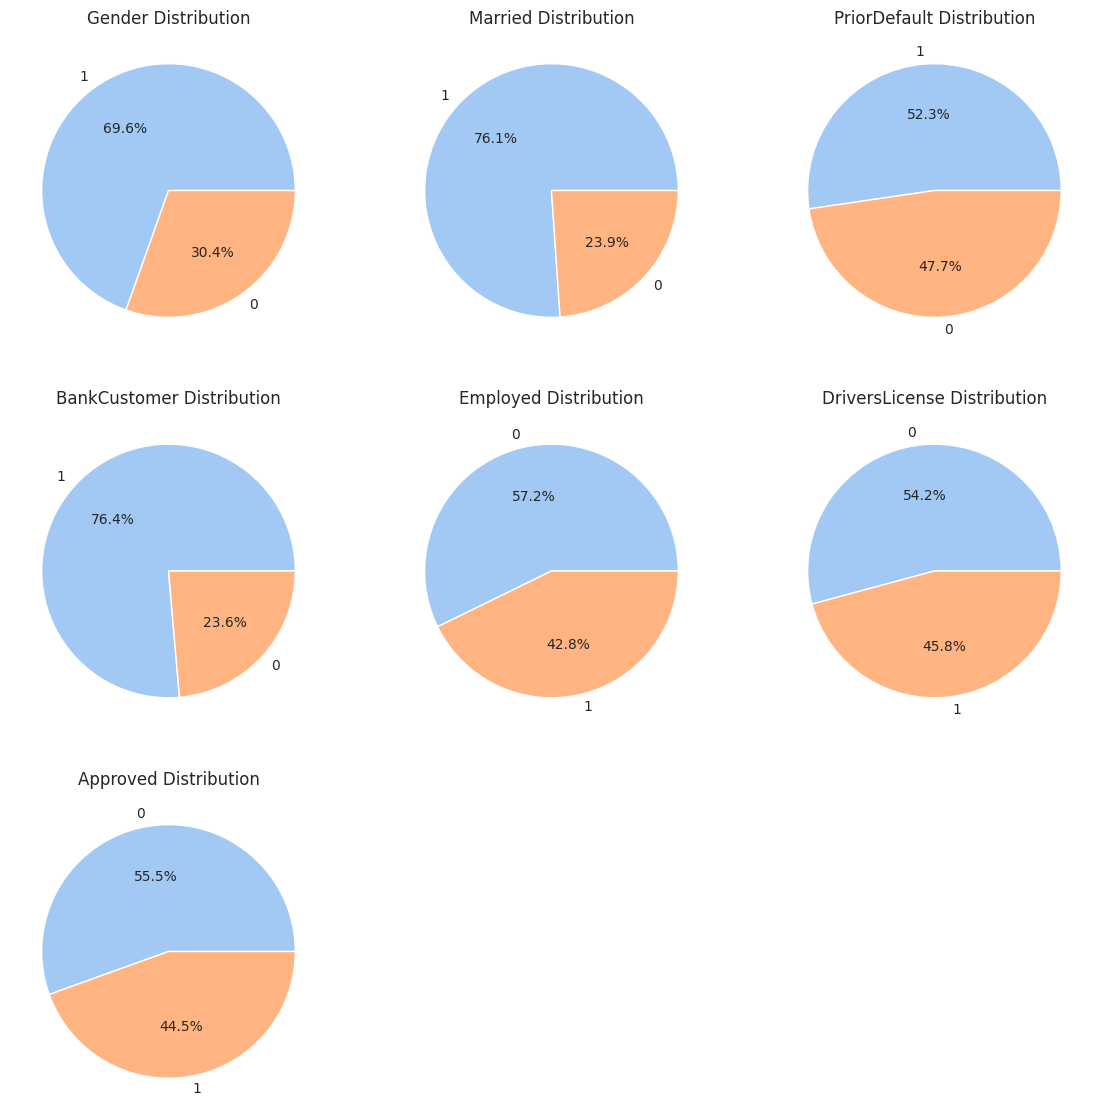

In [61]:
#pie chart for binary distributions
plt.figure(figsize=(14,14))
binary_features = ['Gender','Married','PriorDefault','BankCustomer','Employed','DriversLicense','Approved']
for i,col in enumerate(binary_features):
  pie_plot(col,i+1)
plt.show()

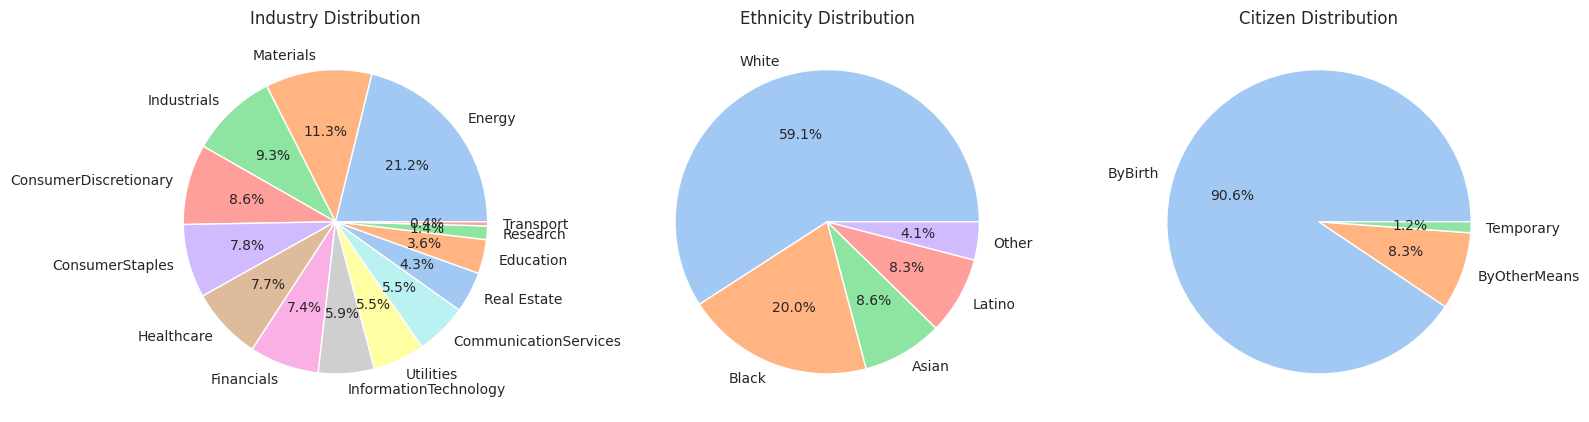

In [62]:
#pie chart for categorical features
plt.figure(figsize=(16,16))
for i,col in enumerate(cat_features):
  pie_plot(col,i+1)

plt.tight_layout()
plt.show()